In [1]:
%load_ext watermark
%watermark -a "Bhavya Kohli" -v

Author: Bhavya Kohli

Python implementation: CPython
Python version       : 3.7.8
IPython version      : 7.30.0



# MoNuSAC Instance Segmentation

<a id="datalink"></a>
This notebook aims to create a Mask-RCNN model using the MoNuSAC data available [**here**](https://monusac-2020.grand-challenge.org/Data/). Due to deprecation issues it is recommended to run this notebook in a virtual environment following the steps described in this [**README**](https://github.com/BhavyaKohli/MoNuSAC-Instance-Segmentation) (available in the repository).

We first confirm the versions of the main libraries, i.e. tensorflow (should be 1.15.0), keras (should be 2.2.5) and h5py (should be 2.10.0). 

In [2]:
%watermark -p tensorflow,keras,h5py

tensorflow: 1.15.0
keras     : 2.2.5
h5py      : 2.10.0



Using TensorFlow backend.


We then run the following cell to silence tensorflow deprecation warnings, since most of the functions and utilities used internally in the mask-rcnn library are deprecated  

In [1]:
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

After downloading the MoNuSAC data mentioned [here](#datalink), extract it to the same directory as the `monusac.ipynb` notebook
The structure of the working directory at this point should be:
```
.
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
└───monusac.ipynb (current notebook)
```

In [2]:
# Importing required libraries
import os, glob, shutil, pathlib
import numpy as np                      
import matplotlib.pyplot as plt
import cv2

import openslide
import tifffile as tif
import xml.etree.ElementTree as ET
import skimage

import tqdm.notebook as tq          # For creating progress bars for "for" loops

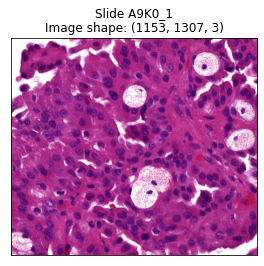

In [3]:
def from_svs(path, display = False, ax = None):
    '''
    Returns an array of shape (X, Y, 3) where (X, Y) are the dimensions of the slide
    stored in .svs format.

    Arguments:
    path - string, path to .svs file
    display -  bool, if True, plots the image created on the axis specified in "ax"
    ax - matplotlib axis object, used for plotting the image created

    Returns:
    img - numpy array of shape (X, Y, 3) containing the image which was stored
          in the .svs file  
    '''

    img = openslide.OpenSlide(path)
    img = np.array(img.get_thumbnail(size = img.level_dimensions[0]), dtype = np.uint8)

    if display:
        ax.imshow(img)
        ax.set_title(f'Slide {path[-10:-4]}\nImage shape: {img.shape}')
        ax.set_xticks([])
        ax.set_yticks([])
    return img

# Displaying a slide image using the above defined function
# using the sample slides in the sample_original directory.
sample_slides = glob.glob('./sample_original/*.svs')
_,ax = plt.subplots()
img = from_svs(sample_slides[0], True, ax)

In [4]:
def generate_and_save_masks(src = './MoNuSAC_images_and_annotations/', 
                            dst = './data/',
                            dst_slides = 'slides', 
                            dst_masks = 'masks', 
                            dst_annots = 'annots', 
                            RESET = False, 
                            slides = True, 
                            masks = True, 
                            annots = True):
    '''
    Generates masks for the annotations in the .xml files and saves
    them as .tif files
    Creates three directories: slides/, masks/ and annots/ (for default dst paths)
    for the respective data.

    Arguments:
    src - string, contains the source directory containing the unzipped contents
          of the MoNuSAC dataset downloaded from https://monusac-2020.grand-challenge.org/Data/
    dst - string, contains directory of the destination folder in which all data created
          will be stored. A directory named "data" will be created in the root folder
          by default.
    dst_slides - string, contains the folder name for the destination of the slides. 
                 The slides are simply renamed, collected and copied to the folder 
                 created in the "dst" directory.
    dst_annots - string, contains the folder name for the destination of the annotations. 
                 The annotations are simply renamed, collected and copied to the folder 
                 created in the "dst" directory.
    dst_masks - string, contains the folder name for the destination of the masks. 
                The annotation files (found as .xml files) are read and all coordinates 
                are extracted. Masks are then created iteratively (one cell at a time) 
                using these coordinates and the skimage module.
    RESET - bool, if set to True, existing folders with the directories set using the above
            arguments will be deleted and recreated.
    slides, masks, annots - bool, if set to True, the files of their respective types will be
                            saved in their respective folders. If set to False, they will be 
                            loaded but not saved. (useful in the case of re-writing just the 
                            slides or just the annotations)

    #########################################################################################
    Example usage:
        dst = './data/',
        num_patients = None,
        dst_slides = 'slides',
        dst_annots = '',
        dst_masks = '',
        RESET = False,
        slides = True,
        masks = False, annots = False

        result: Since reset is false, ignoring the current situation of the main destination 
                directory ('./data'), a folder named 'slides' will be created at './data/slides' 
                and will contain the .svs files extracted from ALL patients (num_patients = None).
                if the destination ('./data/slides') already exists, it will print the error 
                message and not do anything.
    #########################################################################################
    '''
    global label_mapping

    label_mapping = {
        1: 'Epithelial',
        2: 'Lymphocyte',
        3: 'Macrophage',
        4: 'Neutrophil'
    }

    dst_slides = os.path.join(dst, dst_slides)
    dst_masks = os.path.join(dst, dst_masks)
    dst_annots = os.path.join(dst, dst_annots)
    
    try: os.mkdir(dst)
    except: print(f"Directory {dst} already exists")

    if RESET:
        if slides: shutil.rmtree(dst_slides)
        if masks: shutil.rmtree(dst_masks)
        if annots: shutil.rmtree(dst_annots)

    data_path = src
    patients = [x[0] for x in os.walk(data_path)]
    try: 
        bool = True
        if slides: os.mkdir(dst_slides)
        if masks: os.mkdir(dst_masks)
        if annots: os.mkdir(dst_annots)
    except: 
        print("Destination directories already exist. Please rename or delete in case of conflicting names.")
        bool = False

    if bool:        
        for patient_loc in tq.tqdm(patients, unit = 'Patient'):
            patient_name = patient_loc[len(data_path):] #Patient name
            patient_label = patient_name[8:12]
            sub_images = glob.glob(patient_loc + '/*.svs')

            for sub_image in sub_images:
                img = from_svs(sub_image)
                postfix = '_' + sub_image[-5]

                if slides: shutil.copy(sub_image, os.path.join(dst_slides, patient_label + postfix + '.svs'))

                xml_file_name  = sub_image[:-4]
                xml_file_name = xml_file_name+'.xml'
                if annots: shutil.copy(xml_file_name, os.path.join(dst_annots, patient_label + postfix + '.xml'))
                tree = ET.parse(xml_file_name)
                root = tree.getroot()

                for k in range(len(root)):

                    label_postfix = {
                        'Epithelial': '1',
                        'Lymphocyte': '2',
                        'Macrophage': '3',
                        'Neutrophil': '4',
                        'Description': 'X'
                    }

                    for child in root[k]:
                        for x in child:
                            r = x.tag
                            if r == 'Attribute':
                                label = x.attrib['Name']
                                binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8) 

                                cell_type_dir = os.path.join(dst_masks, label_postfix[label])
                                try: os.mkdir(cell_type_dir)
                                except: pass

                            if r == 'Region':
                                vertices = x[1]
                                coords = np.zeros((len(vertices), 2))
                                for i, vertex in enumerate(vertices):
                                    coords[i][0] = vertex.attrib['X']
                                    coords[i][1] = vertex.attrib['Y']

                                vertex_row_coords = coords[:,0]
                                vertex_col_coords = coords[:,1]
                                fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                                
                                binary_mask[fill_row_coords, fill_col_coords] = 1
                                mask_path = os.path.join(cell_type_dir, label + '_' + patient_label + postfix  + '.tif')
                                if masks: cv2.imwrite(mask_path, binary_mask)

    if slides: 
        num_slides = sum(1 for x in pathlib.Path(dst_slides).glob('**/*') if x.is_file())
        print(f"{num_slides} slides were copied to {dst_slides}")
    if masks: 
        num_masks = sum(1 for x in pathlib.Path(dst_masks).glob('**/*') if x.is_file())
        print(f"{num_masks} masks were created at {dst_masks}")
    if annots: 
        num_annots = sum(1 for x in pathlib.Path(dst_annots).glob('**/*') if x.is_file())
        print(f"{num_annots} annotations were copied to {dst_annots}")

In [5]:
# Using the above defined function to store masks, slides, and annotations for
# 5 patients in the "data" folder (using default arguments)
data_path = './MoNuSAC_images_and_annotations/'
generate_and_save_masks(src = data_path, 
                        RESET = False, 
                        slides = True,
                        masks = True, 
                        annots = True
                        )

Directory ./data/ already exists
Destination directories already exist. Please rename or delete in case of conflicting names.
209 slides were copied to ./data/slides
394 masks were created at ./data/masks
209 annotations were copied to ./data/annots


After running the above cell, the working directory should now have the following structure:

```
.
├───data
│   ├───annots
│   ├───masks
│   │   ├───1
│   │   ├───2
│   │   ├───3
│   │   ├───4
│   │   └───X
│   └───slides
├───MoNuSAC_images_and_annotations
├───sample_original
├───README.md
└───monusac.ipynb (current notebook)
```



## Exploring the extracted data

In [6]:
# We create three lists containing paths for slides, masks and annotations.
# We can use these lists for creating plots for visualizing our data and the
# masks created using the `generate_and_save_masks` function
SLIDES_DIR = './data/slides/'
MASKS_DIR = './data/masks/'
ANNOTS_DIR = './data/annots/'


SLIDES = [SLIDES_DIR + filename for filename in os.listdir('./data/slides')]

MASKS_TYPE = dict()
MASKS_ALL = []
for i in np.arange(1,5): 
    MASKS_TYPE[i] =  [MASKS_DIR + str(i) + '/' + filename for filename in [x[2] for x in os.walk('./data/masks')][i]]
    MASKS_ALL = MASKS_ALL + MASKS_TYPE[i]

ANNOTS = [ANNOTS_DIR + filename for filename in os.listdir('./data/annots')]

In [7]:
SLIDES[0][-10:-4]

'1594_1'

In [8]:
def tif_load(path, reshape = True):
    '''
    Returns a 1-D image as a numpy array after loading it from a .tif file
    using the tifffile library

    Arguments:
    path - string, path to the .tif file
    reshape - bool, if True, returns a reshaped array of shape (X, Y, 1) 
              where (X, Y) is the shape of the image stored in the .tif
              file
    
    Returns:
    img - numpy array, contains the image stored in the .tif file
    '''
    img = tif.imread(path)
    if reshape: img = img.reshape(img.shape[0], img.shape[1], 1)
    return img

def tif_show(path, ax):
    '''
    Displays the image stored in a .tif file after loading it using the 
    tifffile library.

    Arguments:
    path - string, path to the .tif file
    ax - matplotlib axis object, the image is plotted on this axis

    Note: 
    The image is displayed using the "Greys" colormap in matplotlib
    '''
    img = tif.imread(path)
    ax.imshow(img, cmap = "Greys")
    ax.set_title("Mask" + " " + path[-10:-4] + "\n" + label_mapping[int(path[13])])
    ax.set_xticks([])
    ax.set_yticks([])

def find_in_list(id, list):
    '''
    Generates a list of all elements in the list "list" which contain "id"

    Arguments:
    id - string, contains the string the function will find in all elements
         of "list"
    list - list

    Returns:
    List containing all elements in the list "list" which contain "id"
    '''
    indices = []
    for i in range(len(list)):
        if id in list[i]: indices.append(i)

    return [list[i] for i in indices]

In [9]:
find_in_list('7760_1', MASKS_ALL)

['./data/masks/2/Lymphocyte_7760_1.tif',
 './data/masks/4/Neutrophil_7760_1.tif']

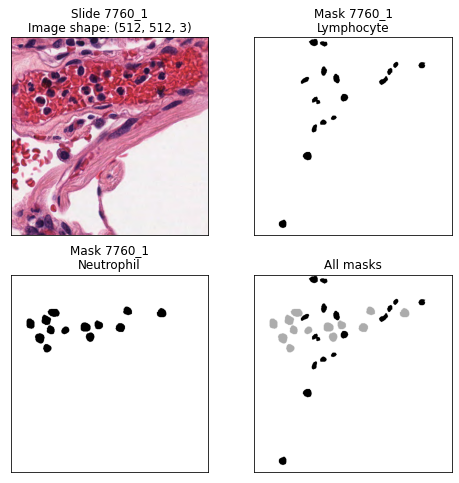

In [10]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
example_slide = from_svs(find_in_list('7760_1', SLIDES)[0], display = True, ax = axes[0,0])
example_list = find_in_list('7760_1', MASKS_ALL)
for i, loc in zip(example_list, [(0,1), (1,0)]):
    tif_show(i, axes[loc])

def modify_mask_values(mask, value):
    '''
    Returns a mask in which all non-zero values of the input mask are replaced 
    by the argument "value"
    '''
    for i in range(len(mask)):
        for j in range(len(mask[0])):
            if mask[i][j] != 0: mask[i][j] = value
    return mask
     
mask_1 = modify_mask_values(tif_load(example_list[0]), 0.7)
mask_2 = modify_mask_values(tif_load(example_list[1]), 0.3)

all_in_one =  mask_1 + mask_2

axes[1,1].imshow(all_in_one, cmap = 'Greys')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_title("All masks")
plt.show()

In [11]:
find_in_list('1594_1', MASKS_ALL)

['./data/masks/1/Epithelial_1594_1.tif',
 './data/masks/2/Lymphocyte_1594_1.tif']

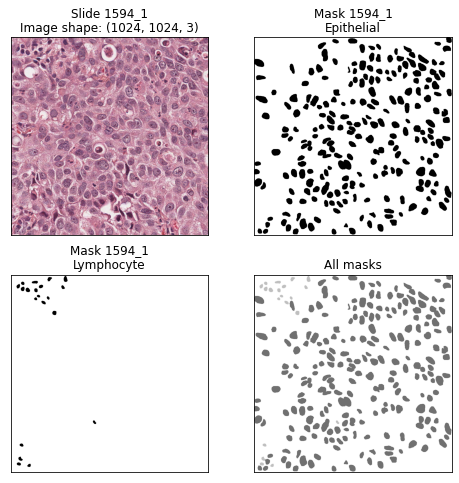

In [12]:
fig, axes = plt.subplots(2,2,figsize=(8,8))
example_slide = from_svs(find_in_list('1594_1', SLIDES)[0], display = True, ax = axes[0,0])
example_list = find_in_list('1594_1', MASKS_ALL)
for i, loc in zip(example_list, [(0,1), (1,0)]):
    tif_show(i, axes[loc])

mask_1 = modify_mask_values(tif_load(example_list[0]), 0.7)
mask_2 = modify_mask_values(tif_load(example_list[1]), 0.4)

all_in_one =  mask_1 + mask_2
axes[1,1].imshow(all_in_one, cmap = 'Greys')
axes[1,1].set_xticks([])
axes[1,1].set_yticks([])
axes[1,1].set_title("All masks")
plt.show()

## Using the Mask-RCNN model on the data

In [13]:
# Importing required utilities from the mask-rcnn library
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import utils
from mrcnn.model import MaskRCNN
from mrcnn import visualize

MODEL_WEIGHTS_PATH = '../mask_rcnn_coco.h5'  # loads model weights using this
LOGS_PATH = './logs'                        # saves logs and checkpoint model weights in this directory

Using TensorFlow backend.


### Defining the dataset class

We now define the dataset class which inherits the base class utils.Dataset from the library. The load function is the basic function which will have to be run each time a dataset is created using this class. It adds all the necessary information about images such as image id, location of annotations, location of slides, etc. to the dataset. All these will then be used in the load_mask and load_image functions (internally) to add the images themselves to the dataset.

In [14]:
class MonuData(utils.Dataset):
    ANNOTS_DIR = './data/annots/'
    MASKS_DIR = './data/masks/'
    SLIDES_DIR = './data/slides/'

    def load(self, train):
        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        slides_list = os.listdir(SLIDES_DIR)
        train_len = int(0.8 * len(slides_list))

        for filename, idx in zip(slides_list, np.arange(len(slides_list))):
            image_id = idx
            patient_id = filename[:-4] 
            img_path = SLIDES_DIR + filename
            annot_path = ANNOTS_DIR + patient_id + '.xml'

            if train and idx > train_len:
                continue
            if not train and idx < train_len + 1:
                continue
            
            self.add_image('cell', 
                           image_id = image_id, 
                           patient_id = patient_id, 
                           path = img_path, 
                           annotation = annot_path)
    
    def load_image(self, image_id, display = False, ax = None):
        info = self.image_info[image_id]
        svs_path = info['path']
        img = from_svs(svs_path, display = display, ax = ax)
        return img

    def load_mask(self, image_id, return_counts = False):
        label_map = {
            'Epithelial': 1,
            'Lymphocyte': 2,
            'Macrophage': 3,
            'Neutrophil': 4
        }

        info = self.image_info[image_id]

        if info["source"] != 'cell':
            return super(self.__class__, self).load_mask(image_id)

        id = info['patient_id']
        annotations_path = info['annotation']

        tree = ET.parse(annotations_path)
        root = tree.getroot()
        img = self.load_image(image_id)
        masks = dict()
        labels = []
        cell_count = [0,0,0,0,0]

        masks = dict()
        count = 0
        for k in range(len(root)):
            for child in root[k]:
                for x in child:
                    r = x.tag
                    if r == 'Attribute':
                        label = x.attrib['Name']
                        label_id = label_map[label]

                    if r == 'Region':
                        binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8)

                        vertices = x[1]
                        coords = np.zeros((len(vertices), 2))
                        for i, vertex in enumerate(vertices):
                            coords[i][0] = vertex.attrib['X']
                            coords[i][1] = vertex.attrib['Y']

                        vertex_row_coords = coords[:,0]
                        vertex_col_coords = coords[:,1]

                        fill_row_coords, fill_col_coords = skimage.draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)

                        binary_mask[fill_row_coords, fill_col_coords] = 1
                        masks[count] = (binary_mask, label_id)
                        labels.append(label_id)
                        cell_count[label_id] += 1
                        count += 1
        keys = list(masks.keys())
        net_mask = masks[keys[0]][0]
        net_labels = [masks[keys[0]][1]]
        for key in keys[1:]:
            net_mask = np.concatenate((net_mask, masks[key][0]), axis = 2)
            net_labels.append(masks[key][1])

        #print(net_mask.shape)
        #print(np.dsplit(net_mask, net_mask.shape[2]).shape)
        
        if not return_counts: return net_mask.astype(np.bool_), np.array(net_labels)
        else: return net_mask.astype(np.bool_), np.array(net_labels), cell_count

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#

In [15]:
# Creating the training dataset
train_dataset = MonuData()
train_dataset.load(train = True)
train_dataset.prepare()

# Creating the validation dataset
val_dataset = MonuData()
val_dataset.load(train = False)
val_dataset.prepare()

In [16]:
# Confirming that the load_mask function works as intended
load_mask_test = train_dataset.load_mask(2)
print(f"Shape of created mask: {load_mask_test[0].shape}", 
      f"Types of masks created: {np.unique([label_mapping[i] for i in load_mask_test[1]])}",
      f"Total number of individual cells: {load_mask_test[0].shape[2]}",
      f"Info about the image: {train_dataset.image_info[2]}", sep = '\n')

print(f"Total matches for the corresponding patient id in the masks archive:\n {find_in_list(train_dataset.image_info[2]['patient_id'], MASKS_ALL)}")

Shape of created mask: (512, 512, 36)
Types of masks created: ['Lymphocyte' 'Macrophage']
Total number of individual cells: 36
Info about the image: {'id': 2, 'source': 'cell', 'path': './data/slides/1594_3.svs', 'patient_id': '1594_3', 'annotation': './data/annots/1594_3.xml'}
Total matches for the corresponding patient id in the masks archive:
 ['./data/masks/2/Lymphocyte_1594_3.tif', './data/masks/3/Macrophage_1594_3.tif']


As we can see above, masks for 2 types of cells are created using the train_dataset.load_mask function for that image, and there are exactly 2 types of cells whose masks are stored in MASKS_ALL (paths)

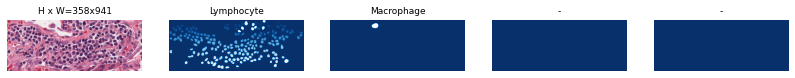

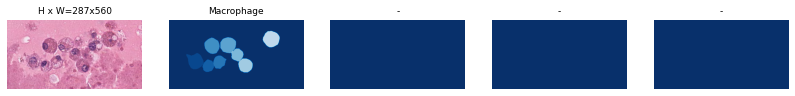

In [19]:
# Visualizing masks for a few slides using the "visualize" utility
image_ids = np.random.choice(train_dataset.image_ids, 2)
for image_id in [8,11]:
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names)

### Defining the model configuration

In [20]:
class MonuConfig(Config):
    NAME = 'MoNuSAC'
    #BACKBONE = 
    IMAGES_PER_GPU = 1              
    NUM_CLASSES = 1 + 4             # Background + 4 cell types
    STEPS_PER_EPOCH = len(train_dataset.image_ids)   
    VALIDATION_STEPS = len(val_dataset.image_ids)
    
    DETECTION_MIN_CONFIDENCE = 0.7  # Setting minimum confidence to 80%
    IMAGE_MIN_DIM = 256             # Minimum image size
    IMAGE_MAX_DIM = 256             # Maximum image size

cfg = MonuConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Defining the model and training it using the datasets created

In [21]:
# MODEL_WEIGHTS_PATH = find_in_list('0005', [x.__str__() for x in pathlib.Path('./logs').glob('**/*')])[0]
# For continuing training, load the weights of the best saved model

model = MaskRCNN(mode = "training", config = cfg, model_dir = LOGS_PATH)
model.load_weights(MODEL_WEIGHTS_PATH, 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [22]:
model.train(train_dataset, 
            val_dataset, 
            learning_rate = cfg.LEARNING_RATE, 
            epochs = 15, 
            layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs\monusac20211205T0107\mask_rcnn_monusac_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Time

c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/15
 35/168 [=====>........................] - ETA: 23:39 - loss: 4.6974 - rpn_class_loss: 1.0660 - rpn_bbox_loss: 1.7366 - mrcnn_class_loss: 0.5836 - mrcnn_bbox_loss: 0.8077 - mrcnn_mask_loss: 0.5035

### Further analysis and visualizations using the trained model

In [18]:
class InferenceConfig(cfg.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.7
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

inf_cfg = InferenceConfig()
inf_cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

### Testing

In [21]:
from shapely.geometry import Polygon

In [72]:
find_in_list('7220_1', MASKS_ALL)

['./data/masks/2/Lymphocyte_7220_1.tif',
 './data/masks/3/Macrophage_7220_1.tif',
 './data/masks/4/Neutrophil_7220_1.tif']

In [81]:
annotations_path = './data/annots/1594_1.xml'
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }
            
tree = ET.parse(annotations_path)
root = tree.getroot()
cell_count = [0,0,0,0,0]

img = from_svs('./data/slides/1594_1.svs')
masks = dict()
#{'Epithelial':dict(),
 #        'Lymphocyte':dict(),
  #       'Macrophage':dict(),
   #      'Neutrophil':dict(),
    #    }
labels = []
count = 0
for k in range(len(root)):
    for child in root[k]:
        for x in child:
            r = x.tag
            if r == 'Attribute':
                label = x.attrib['Name']

            if r == 'Region':
                binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8) 
                idx = cell_count[label_map[label]]
                vertices = x[1]
                coords = np.zeros((len(vertices), 2))
                for i, vertex in enumerate(vertices):
                    coords[i][0] = vertex.attrib['X']
                    coords[i][1] = vertex.attrib['Y']

                vertex_row_coords = coords[:,0]
                vertex_col_coords = coords[:,1]

                fill_row_coords, fill_col_coords = skimage.draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                binary_mask[fill_row_coords, fill_col_coords] = 1
                masks[count] = (binary_mask, label_map[label])
                labels.append(label_map[label])
                cell_count[label_map[label]] += 1
                count += 1

In [98]:
keys = list(masks.keys())
net_mask = masks[keys[0]][0]
net_labels = [masks[keys[0]][1]]
for key in keys[1:]:
    net_mask = np.concatenate((net_mask, masks[key][0]), axis = 2)
    net_labels.append(masks[key][1])

(1024, 1024, 251)